In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

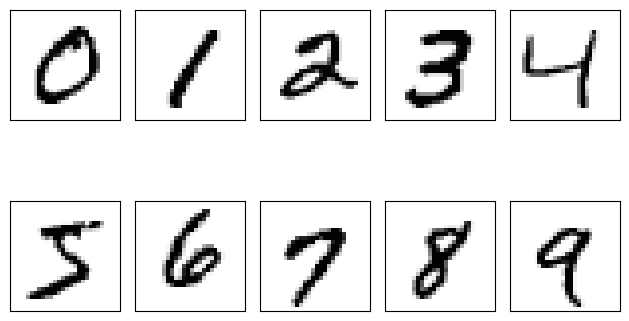

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [35]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on MPS GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

False
False


In [6]:
import torch as t
from sklearn.model_selection import train_test_split

# 80% train; 10% validation; 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train = t.tensor(X_train, dtype=t.float32)
y_train = t.tensor(y_train, dtype=t.long)
X_val = t.tensor(X_val, dtype=t.float32)
y_val = t.tensor(y_val, dtype=t.long)
X_test = t.tensor(X_test, dtype=t.float32)
y_test = t.tensor(y_test, dtype=t.long)

print(f"Training set  : X-{X_train.shape}, y-{y_train.shape}")
print(f"Validation set: X-{X_val.shape}, y-{y_val.shape}")
print(f"Test set      : X-{X_test.shape}, y-{y_test.shape}")

Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


In [39]:
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on CUDA GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on MPS GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

net.to(device)

Running on CPU


Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [40]:
# loss_function = nn.CrossEntropyLoss()
loss_function = F.cross_entropy

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

total_batches = len(train_loader)
print(f"Total batches: {total_batches}")
log_interval = max(1, math.floor(total_batches / 20))
print(f"Log interval : every {log_interval} batches")

train_losses = []
val_losses = []

Total batches: 875
Log interval : every 43 batches


In [41]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):  # loop over the dataset multiple times

    running_training_loss = 0
    total_train_samples = 0
    net.train()  # Set the network to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # weighted average of the training loss
        running_training_loss += loss.item() * inputs.shape[0]
        total_train_samples += inputs.shape[0]
        # Log at the specified interval
        if (i + 1) % log_interval == 0 or i == 0 or i == total_batches - 1:
            # Training loss
            avg_training_loss = running_training_loss / total_train_samples
            train_losses.append(avg_training_loss)
            # Validation loss
            net.eval()  # Set the network to evaluation mode
            # weighted average of the validation loss
            running_val_loss = 0
            total_val_samples = 0
            with t.no_grad():
                for val_data in val_loader:
                    inputs, labels = val_data
                    outputs = net(inputs)
                    val_loss = loss_function(outputs, labels)
                    running_val_loss += val_loss.item() * inputs.shape[0]
                    total_val_samples += inputs.shape[0]
            avg_val_loss = running_val_loss / total_val_samples
            val_losses.append(avg_val_loss)
            net.train()  # Set the network back to training mode

            print(f'[{epoch + 1}, {i + 1}] avg training loss: {avg_training_loss:.3f}, avg validation loss: {avg_val_loss:.3f}')
            running_training_loss = 0
            total_train_samples = 0

print('Finished Training')

[1, 1] avg training loss: 2.319, avg validation loss: 2.327
[1, 43] avg training loss: 0.997, avg validation loss: 0.534
[1, 86] avg training loss: 0.509, avg validation loss: 0.405
[1, 129] avg training loss: 0.389, avg validation loss: 0.391
[1, 172] avg training loss: 0.378, avg validation loss: 0.354
[1, 215] avg training loss: 0.385, avg validation loss: 0.360
[1, 258] avg training loss: 0.366, avg validation loss: 0.338
[1, 301] avg training loss: 0.327, avg validation loss: 0.314
[1, 344] avg training loss: 0.314, avg validation loss: 0.272
[1, 387] avg training loss: 0.270, avg validation loss: 0.305
[1, 430] avg training loss: 0.267, avg validation loss: 0.274
[1, 473] avg training loss: 0.266, avg validation loss: 0.233
[1, 516] avg training loss: 0.271, avg validation loss: 0.237
[1, 559] avg training loss: 0.249, avg validation loss: 0.232
[1, 602] avg training loss: 0.246, avg validation loss: 0.207


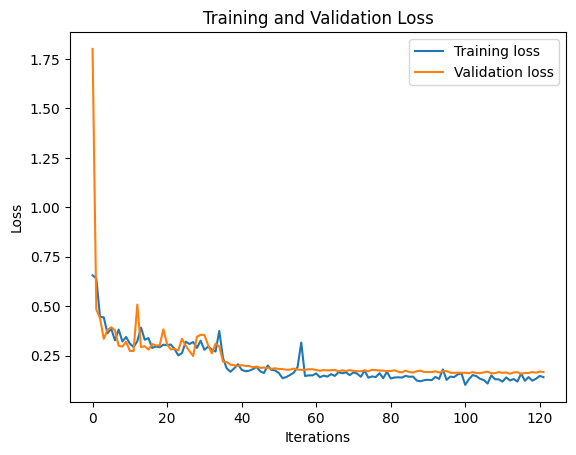

In [ ]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()